# 讯飞算法赛--农作物生长情况识别挑战赛（PaddleClas实现版本）

比赛传送门: [讯飞算法赛--农作物生长情况识别挑战赛](https://challenge.xfyun.cn/topic/info?type=crop)

- 注册账号要实名，才能报名

- 每天只能提交3次

- 基线分数:0.9913

> 本项目基线依托于[PaddleClas](https://github.com/PaddlePaddle/PaddleClas)实现搭建，欢迎大家前往Star


# 一、赛事背景
随着物联网和大数据技术的飞速发展，智慧农业已经是智慧经济的重要组成部分。我国是农业大国，而非农业强国，因此要实现高水平的设施农业生产和优化设施生物环境控制，农业相关信息获取、分析技术是农业生产中最关键的技术之一。

农作物的生长态势，事关农事生产的整个过程，因此通过农作物不同时期图片，对农作物进行合理的农作物生产态势检测，对于农业生产是十分有必要的。通过分析农作物生长情况，最大程度地判断农作物生长态势，合理调配生产资源，为农作物生产管理人员或管理决策者提供及时可靠的长势信息，便于及时采集有效的田间管理措施，对农作物产量进行准确预估，为我国人民的生存条件和粮食安全提供保障。

# 二、赛事任务
通过作物不同生长时期的特点可以对作物的生长情况进行识别，给出合理的作物生长阶段。本次大赛提供了大量草莓植株在营养生长阶段的生长情况图片作为样本，参赛选手需基于提供的样本构建模型，对草莓样本生长态势进行检测，判断其生长情况，并将生长情况在csv文件中对应标定出来，给出草莓图像对应的生长阶段。

初赛一阶段：6月21日到8月18日。

初赛二阶段：8月19日到8月20日。系统将在8月19日00：00更换测试数据，参赛队伍需要再次下载数据。

# 三、分类类别
本次比赛为选手提供草莓处于营养生长阶段的图片作为数据集，其中包含有作物图片及生长情况标签。选手根据训练集进行训练，对测试集数据进行标定，判断所标定的作物处于何种生长情况之下。草莓生长阶段大致可以分为以下几个阶段：生长期、开花期、结果期、成熟期。

0，草莓生长期

1，草莓开花期

2，草莓结果期

3，草莓成熟期

# 四、1.初赛数据下载链接

1.[训练与测试数据集(几十M)](https://ai-contest-static.xfyun.cn/2021/7beb7ecc-97ce-4c58-97f2-e93a7d64cd30/%E4%B8%AD%E5%9B%BD%E5%86%9C%E4%B8%9A%E5%A4%A7%E5%AD%A6_%E5%86%9C%E4%BD%9C%E7%89%A9%E7%94%9F%E9%95%BF%E6%83%85%E5%86%B5%E8%AF%86%E5%88%AB%E6%8C%91%E6%88%98%E8%B5%9B_%E6%95%B0%E6%8D%AE%E9%9B%86.zip)

2.[提交示例文件](https://ai-contest-static.xfyun.cn/2021/a679cb33-6a7a-4f64-9014-6624b8c9e66d/%E4%B8%AD%E5%9B%BD%E5%86%9C%E4%B8%9A%E5%A4%A7%E5%AD%A6_%E5%86%9C%E4%BD%9C%E7%89%A9%E7%94%9F%E9%95%BF%E6%83%85%E5%86%B5%E8%AF%86%E5%88%AB%E6%8C%91%E6%88%98%E8%B5%9B/submit_sample.csv)

> 建议下载后上传数据集，该数据集不支持公开，个人比赛使用即可

# 四、2.数据分析

> 解压数据后，可自行查看数据情况

## 2.1 类别差异分析

> 通过可视化随机采样的16张图片进行观察，可以发现四种类别差异很大

> 这也对使用`EfficientNetB0`模型可以取得不错的成绩提供了一定的数据支撑

> 0. 生长期没有花也没有草莓，需要学习物体本质的判断(深层)，且容易受到其它类别的样本干扰

> 1. 开花对应不同的形状，容易学习形状特征判断(浅层)

> 2. 结果与成熟期，颜色差异大，易学习颜色特征(浅层)

<font color='red' font-size=24> 该任务主要是一些明显的浅层特征，所以可以先尝试轻量化模型，大模型可能导致过拟合 </font>

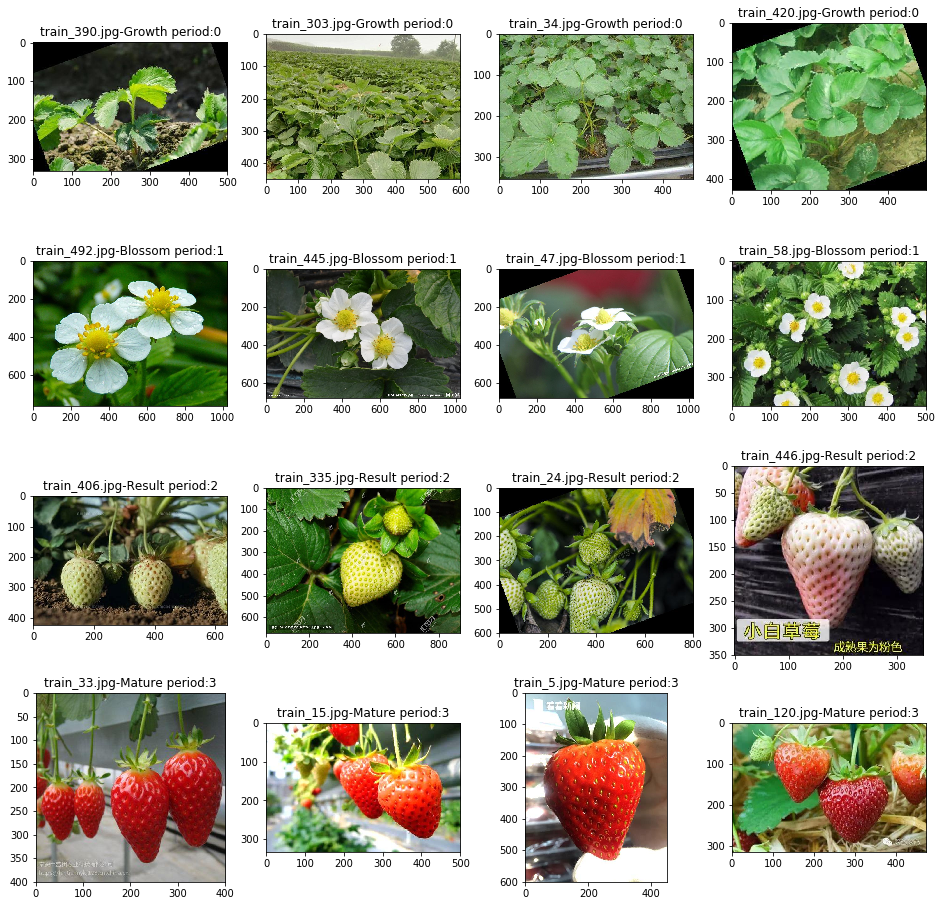

In [3]:
import os
import numpy as np
import pandas as pd

import cv2
from matplotlib import pyplot as plt

img_root = '/home/aistudio/PaddleClas/dataset/agriculture/train'
train_cls_info = pd.read_csv('/home/aistudio/PaddleClas/dataset/agriculture/train.csv')

show_imgs = []
show_names = []
show_clses = []
# ['草莓生长期', '草莓开花期', '草莓结果期', '草莓成熟期']
Clas_names = ['Growth period', 'Blossom period', 'Result period', 'Mature period']

# 分别随机采样4个不同类别的样本图片
for cls in range(len(Clas_names)):
    sample_datas = train_cls_info[train_cls_info.iloc[:, 1] == cls].sample(4, random_state=2021)
    for i in range(len(sample_datas)):
        img_name = sample_datas.iloc[i, 0]
        img_cls  = sample_datas.iloc[i, 1]

        img_path = os.path.join(img_root, img_name)

        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB).astype(np.uint8)

        show_imgs.append(img)  # img
        show_names.append(img_name)  # img_name
        show_clses.append(int(img_cls))  # cls_id

fig, axs = plt.subplots(4, 4, figsize=(16, 16))

for i in range(len(axs)):
    for j in range(len(axs[i])):
        axs[i, j].imshow(show_imgs[i*4 + j])
        axs[i, j].set_title(show_names[i*4 + j] + '-' + Clas_names[show_clses[i*4 + j]] + ':' + str(show_clses[i*4 + j])) # cls_name

## 2.2 分析类别分布

> 该样本数据集类别分布均衡，训练理论上应该较为顺利，因此，放心尝试一些数据增强的方法来扩充数据集是简单的

> 其中,成熟期样本相对较少，但整体上分布较为均匀，因此，不妨直接进行数据扩充即可，不必放重心在样本平衡上

> 共**557张**训练图片

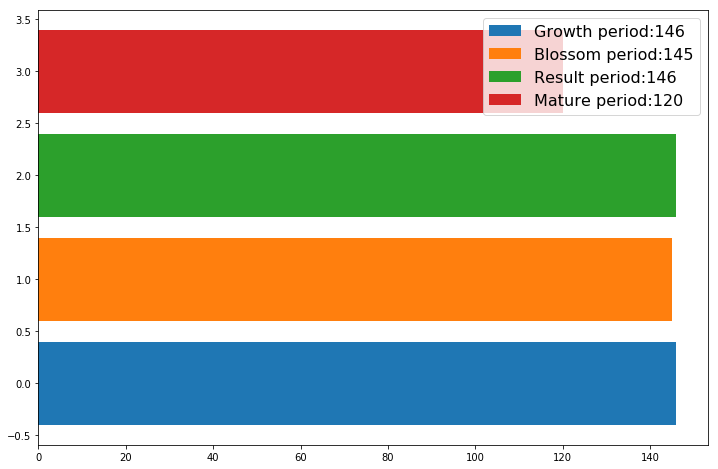

In [9]:
cls_idxs = train_cls_info.iloc[:, 1].to_numpy()

cls_counts = [0] * 4

# 统计类别数
for cls in cls_idxs:
    cls_counts[cls] += 1

# 绘图
fig = plt.figure(figsize=(12, 8))
for i in range(len(cls_counts)):
    plt.barh(i, cls_counts[i], label=Clas_names[i] + ':' + str(cls_counts[i]))

plt.legend(fontsize=16)

> 各类别数量如图中标注所示

- ['Growth period', 'Blossom period', 'Result period', 'Mature period']

- [146, 145 ,146, 120]

# 五、配置比赛环境

- [PaddleClas](https://github.com/PaddlePaddle/PaddleClas)套件，辅助快速实现比赛.欢迎Star-Fork

- 本赛题类别较少，可以先尝试轻量化模型，再转入更深的网络模型

- EfficientNetB0模型，实现了**0.9913**的成绩

## 1.解压PaddleClas套件

已经自带，无需再解压，可放心使用

> 如果多次(>=2次)执行该代码块，不会造成无法运行的结果，只是会在PaddleClas目录下多一个`PaddleClas-release-2.1`文件夹

In [ ]:
# !unzip -o data/data90342/PaddleClas-release-2.1.zip
# !mv PaddleClas-release-2.1 PaddleClas

## 2.解压数据集

如果项目未自带数据集，请自行下载一下数据集~

请自行上传下载好的比赛数据集，只需要修改一下cell中的代码即可整个项目自动无误的运行

> 将data目录下的**data98233**换成当前上传后数据集的目录即可

> !unzip -o data/data98233/中国农业大学_农作物生长情况识别挑战赛_数据集.zip -d PaddleClas/dataset/

最终，数据集会存放在`PaddleClas/dataset/agriculture`文件夹下

In [1]:
!unzip -o data/data98233/中国农业大学_农作物生长情况识别挑战赛_数据集.zip -d PaddleClas/dataset/
!mv PaddleClas/dataset/中国农业大学_农作物生长情况识别挑战赛_数据集 PaddleClas/dataset/agriculture

## 3.执行数据集的划分

> 直接运行即可，无需修改

> 也可修改该文件中的`split_rate`实现**训练-验证**数据的划分比例修改

- `split_data.py` 会根据`PaddleClas/dataset/agriculture`下的**csv**自动划分数据

- 划分的数据存放在train_list.txt、val_list.txt文件中

> 本划分未提供全量数据的划分，可以自行创建一个`all_list.txt`文件，然后复制`train_list.txt`和`val_list.txt`中的样本放入保存在`PaddleClas/dataset/agriculture`目录下即可

- 每个文件中的一行样本，都是由当前目录下数据的 `相对路径 + 空格 + 标签` 组成

In [ ]:
# %cd 表示切换当前工作目录到指定目录下
%cd /home/aistudio/
!python split_data.py

## 4.模型配置文件yml的使用说明

- 以EfficientNetB0为例

|步骤|路径|操作描述|
| -------- | -------- | -------- |
| 1 | 进入PaddleClas目录| 进入套件 |
| 2 | 进入PaddleClas/configs目录| 进入模型配置文件夹 |
| 3 | 进入PaddleClas/configs/EfficientNet目录| 进入EfficientNet模型配置ymls |
| 4 | 在PaddleClas/configs/EfficientNet目录下| 选中需要的fficientNet模型配置yml，进入修改模型配置 |
| 5 | 在PaddleClas/configs/EfficientNet目录下| 保存模型配置修改 |
| 6 | 退回PaddleClas目录| 寻找tools文件夹 |
| 7 | 进入PaddleClas/tools目录| 找到train.py |
| 8 | 在notebook中执行train.py， 并将我们配置好的模型路径传入该py文件中执行| 执行train.py，开始模型训练 |
| 9 | 训练完成后，进入PaddleClas/tools/infer目录| 找到infer.py |
| 10 | 在notebook中执行infer.py | 得到预测结果，然后后处理提交预测结果作为比赛结果(具体预测处理在预测阶段说明) |


> 本项目就按照EfficientNetB0模型的配置，以及使用进行简单说明，使用其它的模型只需要做相应修改即可

### 4.1 在模型配置yml中的修改

```
mode: 'train'
ARCHITECTURE:
    name: "EfficientNetB0"
    params:
        padding_type : "SAME"
        override_params:
            drop_connect_rate: 0.1

pretrained_model: ""
model_save_dir: "./output/"
# 分类数目要对应比赛中的分类数
classes_num: 4
# 参与训练的图片数量 -- 训练加验证的总数：这里就是557
total_images: 557
# 保存的频率，即25轮保存一次模型
# 且同时会保存当前最优的模型
save_interval: 25
# 边训练边验证
validate: True
# 验证的频率，即25轮验证一次训练的模型
valid_interval: 25
# 总的训练轮次
epochs: 360
# top数，即预测的前几个类别的平均精度
# topk >= classes_num
topk: 4
# 输入图片大小
# 如果要修改，建议同下边的数据加载的预处理图片大小一起修改
image_shape: [3, 224, 224]
# 指数平滑，其它参数就不解释了。下次有机会再解释(别说我不知道，看破别说破_O(∩_∩)O)
use_ema: True
ema_decay: 0.9999
use_aa: True
ls_epsilon: 0.1

# 学习率策略的配置
# 支持——余弦+预热，余弦，多项式衰减，指数预热
# 详细可前往——PaddleClas/ppcls/optimizer/learning_rate.py查看
# 相关替换，可以比对着类初始化参数配置
# 也可以参考下其它模型配置文件的组合方式
LEARNING_RATE:
    function: 'ExponentialWarmup'
    params:
    	  # 学习率大小
        lr: 0.032

# 模型优化的配置
# 支持Momentum ， RMSProp
# 详细可前往——PaddleClas/ppcls/optimizer/optimizer.py查看
# 相关替换，可以比对着类初始化参数配置
# 也可以参考下其它模型配置文件的组合方式
OPTIMIZER:
	 # 优化方法
    function: 'RMSProp'
    params:
    	  # 动量大小
        momentum: 0.9
        rho: 0.9
        epsilon: 0.001
    regularizer:
        # 正则化方法--L2
        # 也支持L1
        function: 'L2'
        factor: 0.00001

# 数据集配置
# 训练集配置 -- 很简单，一学就会，立马能用
TRAIN:
	 # 在原配置基础上，适当调整下batch_size
    batch_size: 64
    # notebook中，记得置零多线程，否则数据读取器会报错
    # 也可以自己修改成dist系列的读取器，不过没太大必要，这里就不多说了
    num_workers: 0
    # 训练数据集的样本索引txt -- 就是之前数据划分生成的训练文件
    # 这里时相对路径哦 -- 在PaddleClas下的相对路径
    file_list: "./dataset/agriculture/train_list.txt"
    # 之前有说道，txt中存放的路径是相对路径
    # 因此，这里需要把图片的完整路径补上，这样数据才能读取成功
    # 假设train_list中的样本1： train_143.jpg 0
    # 拼接后，./dataset/agriculture/train/train_143.jpg
    # 这样就能保证数据的读取了
    data_dir: "./dataset/agriculture/train/"
    shuffle_seed: 0
    transforms:
    	  # 编码图片数据，通过numpy读取文件中的uint8数据
        # 然后用opencv解码出图片数据
        - DecodeImage:
        	  # 转成RGB格式
            to_rgb: True
            # 通道不提前，保持数据格式[W,H,C]
            channel_first: False
        # 随机裁剪
        - RandCropImage:
            # 裁剪大小
            size: 224
            interpolation: 2
        # 随机翻转
        - RandFlipImage:
            # 翻转的模型
            flip_code: 1
        - AutoAugment:
        # 归一化，可根据数据本身的分布进行修改，也可以不做修改
        - NormalizeImage:
            scale: 1./255.
            mean: [0.485, 0.456, 0.406]
            std: [0.229, 0.224, 0.225]
            order: ''
        # 通道提前
        - ToCHWImage:

# 验证数据集的配置与训练数据集的配置类似
VALID:
    batch_size: 64
    num_workers: 0
    # 替换成验证集划分的索引数据txt就好了
    file_list: "./dataset/agriculture/val_list.txt"
    # 对应的路径，如果存放路径相同就直接copy训练集的完整目录配置就好
    data_dir: "./dataset/agriculture/train/"
    # 其它的也差不多了
    shuffle_seed: 0
    transforms:
        - DecodeImage:
            to_rgb: True
            channel_first: False
        - ResizeImage:
            interpolation: 2
            resize_short: 256
        - CropImage:
            size: 224
        - NormalizeImage:
            scale: 1.0/255.0
            mean: [0.485, 0.456, 0.406]
            std: [0.229, 0.224, 0.225]
            order: ''
        - ToCHWImage:

```

> 完成以上的配置，该模型文件就完成的基本的参数配置以及数据集的配置了

> 接下来就可以上手**train.py**开始训练了

### 4.2运行train.py开始训练

train的基本使用有两种：

- 1. !python tools/train.py -c 模型配置文件yml的路径

	eg:
    
        按照EfficientNetB0进行训练: !python tools/train.py -c configs/EfficientNet/EfficientNetB0.yaml
        
    
- 2. !python tools/train.py -c configs/EfficientNet/EfficientNetB0.yaml -o 通过参数名在线修改模型配置文件中的参数信息
    
   eg:
   
   		1.加载预训练模型(再/续训练) !python tools/train.py -c configs/EfficientNet/EfficientNetB0.yaml -o pretrained_model='output/EfficientNetB0/best_model/ppcls'
        
        2.修改模型分类数 !python tools/train.py -c configs/EfficientNet/EfficientNetB0.yaml -o classes_num=4
      
      
> -o 的其它使用就要靠大家去多多探索了

## 5. 训练模型

运行下方`cell`即可开始训练

> 更换其它模型时，请记得修改对应yml文件中的必要参数

> 比如**数据集路径**、**分类数**、**图片总数**、**总轮次**、**保存/验证频率**、以及**学习率**和**topk数**

> 详细可看上面的yml介绍

In [ ]:
# 切换工作目录到PaddleClas下
%cd PaddleClas
# 此时运行程序可以直接运行PaddleClas下的程序和文件
# -c 配置训练文件
!python tools/train.py -c configs/EfficientNet/EfficientNetB0.yaml

## 6. 预测结果

- 预测程序为 `PaddleClas/tools/infer/infer.py`

相关参数如下：

- image_file(可简写 i)：待预测的图片文件路径或者批量预测时的图片文件夹，如 ./test.jpeg 或者 test
- model：模型名称，如 MobileNetV3_large_x1_0  -- 就是yml中name的字符串(通常就等于模型的yml名称)
```
ARCHITECTURE:
    name: "EfficientNetB0"
    params:
        padding_type : "SAME"
        override_params:
            drop_connect_rate: 0.1
```
- pretrained_model：模型权重文件路径，如 ./output/MobileNetV3_large_x1_0/best_model/ppcls
- use_gpu : 是否开启GPU训练，默认值：True
- class_num : 类别数，默认为1000，需要根据自己的数据进行修改。
- resize_short: 对输入图像进行等比例缩放，表示最短边的尺寸，默认值：256
- resize: 对resize_short操作后的进行居中裁剪，表示裁剪的尺寸，默认值：224
- pre_label_image : 是否对图像数据进行预标注，默认值：False
- pre_label_out_idr : 预标注图像数据的输出文件夹，当pre_label_image=True时，会在该文件夹下面生成很多个子文件夹，每个文件夹名称为类别id，其中存储模型预测属于该类别的所有图像。

> 注意，`pre_label_image`设置为True，`pre_label_out_idr`才有意义，才会有预测结果的保存

> 测试数据集在`dataset/agriculture/test/testA`目录下

> 模型输出到`PaddleClas/output`

In [ ]:
%cd PaddleClas
!python tools/infer/infer.py \
--image_file 'dataset/agriculture/test/testA'\
--model 'EfficientNetB0'\
--pretrained_model 'output/EfficientNetB0/best_model/ppcls'\
--pre_label_image True\
--pre_label_out_idr './output'\
--class_num 4

# 六、生成比赛提交结果

- 保存提交**csv**在首目录

In [ ]:
import pandas as pd
import numpy as np
import os

# 明确类别数
class_num = 4
# 所有的预测结果
class_results = []

# 根据类别数遍历output下的预测结果
for i in range(class_num):
    find_root = '/home/aistudio/PaddleClas/output'
    find_dir_id = str(i)
    find_dir_path = os.path.join(find_root, find_dir_id)
    # 遍历当前类别文件夹下的图片
    for _, _, files in os.walk(find_dir_path):
        files = np.asarray(files)
        files = np.reshape(files, (-1, 1))
        # 将当前的类别i，拼接到当前类别预测文件夹下每一个图片ndarray中
        files = np.concatenate([files, np.full_like(files, i)], axis=-1)
        # 逐一遍历并添加到分类结果中
        for f in files:
            # f[0] 图片名称
            # int(f[1]) 类别结果(数字)
            class_results.append([f[0], int(f[1])])

# 将得到的所有预测结果进行后处理输出
result = []
for i in range(len(class_results)):
    for res in class_results:
        if int(res[0].split('.')[0].split('_')[1]) == (i+1):
            result.append(res)
            # 移除掉list中的该数据
            class_results.remove(res)
            break
result = np.asarray(result)

# 转换为DataFrame，方便保存提交csv文件
result_df = pd.DataFrame(result)
# 根据提交要求设置列名
result_df.columns=['image_id', 'category_id']
# index=None，不保存序列号
result_df.to_csv('/home/aistudio/submit_sample.csv', index=None)
result_df.head()

> 做完以上工作就可以将`submit_sample.csv`提交到对应的比赛了

> 祝大家取得好成绩!

> 有问题欢迎评论区讨论

> 姓名：蔡敬辉

> 学历：大三（在读）

> 爱好：喜欢参加一些大大小小的比赛，不限于计算机视觉——有共同爱好的小伙伴可以关注一下哦~后期会持续更新一些自制的竞赛baseline和一些竞赛经验分享

> 主要方向：目标检测、图像分割与图像识别--在学习NLP, 正在捣鼓FPGA

> 联系方式：qq:3020889729 微信:cjh3020889729

> 学校：西南科技大学